This document aims to design and implement toy experiements for the paper *Gradient Estimators for Impicit Models, Yingzhen Li and Richard E. Turner, 2017*. We compare three kernel-based methods: Stein Gradient Estimator, Kernel Density Estimator, and Score Matching Gradient Estimator. In this document, we always assume a Gaussian Kernel with bandwidth $\sigma$. (default $\sigma = 1$)

Case 1.  
We set the implicit model as $x=\frac{1}{1+e^{z_1}+e^{z_2}}$, where the latent variables $z_1\sim N(0,1)$ and $z_2\sim N(0,1)$ are independent. Given $K=100$ sample points $x_1,\cdots,x_K$, we apply the *Stein Gradient Estimator*, the *Kernel Density Estimator*, and the *Score Matching Gradient Estimator* and compare the results.

Case 2.  
We repeat case 1 except that we set the implicit model as $x\sim N(0,1)$, so we actually know the true gradients. we apply the *Stein Gradient Estimator*, the *Kernel Density Estimator*, and the *Score Matching Gradient Estimator* and compare the results as well as the true gradients.

In [1]:
#--------------packages--------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import normal

In [2]:
#--------------Data Generating Process---------#
def data1(K):
    z1 = normal(0, 1, K)
    z2 = normal(0, 1, K)
    x = 1 / (1 + np.exp(z1) + np.exp(z2))
    return x

def data2(K):
    x = normal(0, 1, K)
    return x

In [3]:
#----Gaussian Kernel Function----#
def Gaussian_Kernel(x1, x2, sigma = 1):
    return np.exp(- (x1 - x2) ** 2 / (2 * sigma ** 2))

def nabla_Gaussian_Kernel(x1, x2, sigma = 1):
    return - (x1 - x2) / (sigma ** 2) * np.exp(- (x1 - x2) ** 2 / (2 * sigma ** 2))

In [4]:
#--------------Stein Gradient Estimator--------#
def Stein_Gradient_Estimator(x, sigma = 1):
    K = len(x)
    KK = np.mat(np.zeros((K,K)))
    nabla_KK = np.mat(np.zeros((K,K)))
    
    for i in range(K):
        for j in range(K):
            KK[i,j] = Gaussian_Kernel(x[i], x[j], sigma)
    
    for i in range(K):
        for k in range(K):
            nabla_KK[i, k] = nabla_Gaussian_Kernel(x[i], x[k], sigma)
        
    eta = 1
    I = np.identity(K)
    L = np.mat(np.ones(K)).T
    
    G = np.mat(np.linalg.inv(KK + eta * I)) * nabla_KK * L
    
    return G

In [23]:
#-------------Kernel Density Estimator------------#
def KDE(x, sigma = 1):
    K = len(x)
    G = np.zeros(K)
    
    KK = np.mat(np.zeros((K,K)))
    nabla_KK = np.mat(np.zeros((K,K)))
    
    for i in range(K):
        for j in range(K):
            KK[i,j] = Gaussian_Kernel(x[i], x[j], sigma)
    
    for i in range(K):
        for k in range(K):
            nabla_KK[i, k] = nabla_Gaussian_Kernel(x[i], x[k], sigma)
        
    for i in range(K):
            G[i] = np.sum(nabla_KK[i,:]) / np.sum(KK[i,:])
    
    return np.mat(G).T

In [6]:
#-------------Score Matching Gradient Estimator---#
def Score_Matching_Gradient_Estimator(x, sigma =1):
    K = len(x)
    G = np.zeros(K)
    
    KK = np.mat(np.zeros((K,K)))
    nabla_KK = np.mat(np.zeros((K,K)))
    L = np.mat(np.ones(K)).T
    
    for i in range(K):
        for j in range(K):
            KK[i,j] = Gaussian_Kernel(x[i], x[j], sigma)
            
    for i in range(K):
        for k in range(K):
            nabla_KK[i, k] = nabla_Gaussian_Kernel(x[i], x[k], sigma)
    
    v = sigma ** 2 * KK * L - (KK * np.mat(x ** 2).T + np.diag(x) * KK * L - 2 * np.diag(x) * KK * np.mat(x).T)
    
    Sigma = (np.diag(x) * KK - KK * np.diag(x)) * (KK * np.diag(x) - np.diag(x) * KK)
    
    eta = 1
    I = np.identity(K)
    
    a = np.linalg.inv(Sigma + eta * I) * v
    
    G = nabla_KK * a
    
    return G

In [29]:
#--------------True Gradients in Case 2------------#
def Gradients(x):
    return - np.mat(x).T

In [8]:
K = 100
np.random.seed(10)
x1 = data1(K)
x2 = data2(K)

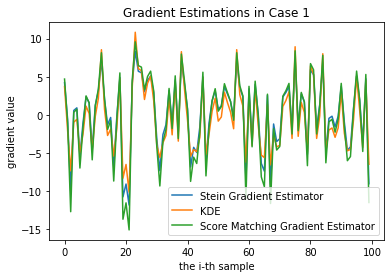

In [30]:
#-------------Case 1--------------------#
plt.plot(Stein_Gradient_Estimator(x1), label = 'Stein Gradient Estimator')
plt.plot(KDE(x1, sigma = 0.1), label = 'KDE')
# one needs to change the sigma in KDE here
plt.plot(Score_Matching_Gradient_Estimator(x1), label = 'Score Matching Gradient Estimator')
plt.xlabel('the i-th sample')
plt.ylabel('gradient value')
plt.title('Gradient Estimations in Case 1')
plt.legend()
#plt.savefig('case1.pdf')
plt.show()

Conclusion 1: three methods have similar results in Case 1.

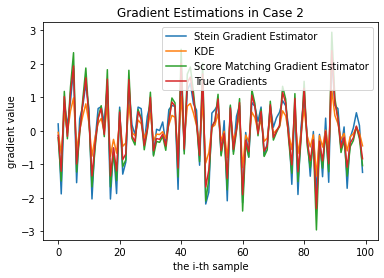

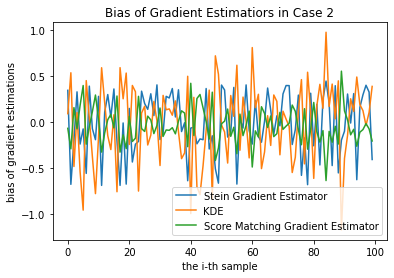

In [31]:
#-------------Case 2--------------------#
#-----plot 1------#
plt.plot(Stein_Gradient_Estimator(x2), label = 'Stein Gradient Estimator')
plt.plot(KDE(x2), label = 'KDE')
plt.plot(Score_Matching_Gradient_Estimator(x2, sigma = 8), label = 'Score Matching Gradient Estimator')
# one needs to change the sigma in Score Matching Gradient Estimator here
plt.plot(Gradients(x2), label = 'True Gradients')
plt.xlabel('the i-th sample')
plt.ylabel('gradient value')
plt.title('Gradient Estimations in Case 2')
plt.legend()
#plt.savefig('case2.pdf')
plt.show()

#------plot 2: bias------#
plt.plot(Stein_Gradient_Estimator(x2) - Gradients(x2), label = 'Stein Gradient Estimator')
plt.plot(KDE(x2) - Gradients(x2), label = 'KDE')
plt.plot(Score_Matching_Gradient_Estimator(x2, sigma = 8) - Gradients(x2), label = 'Score Matching Gradient Estimator')
# one needs to change the sigma in Score Matching Gradient Estimator here
plt.xlabel('the i-th sample')
plt.ylabel('bias of gradient estimations')
plt.title('Bias of Gradient Estimatiors in Case 2')
plt.legend()
#plt.savefig('case2.pdf')
plt.show()

Conclusion 2: three methods not only coincide with each other, but have accurate estimations compared to the true gradients.

Remark: fine-tuning the bandwith may produce a better result for all of methods, but the paper **does not** provide a method for parameter tuning. Also, finding a good kernel is also important. This issue may be the same as the nonparametric statistics, where kernels like Gaussian or Epanechnikov have similar results while the **bandwidth plays a much more important role** in the estimation.